In [1]:
import os
os.environ["CPP_TF_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd

In [2]:
tf.random.set_seed(47)

In [3]:
metrics = [tf.keras.metrics.RootMeanSquaredError()]

2022-10-10 15:18:18.972762: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
train_ds = pd.read_csv("../input/feedback-prize-english-language-learning/train.csv")
test_ds = pd.read_csv("../input/feedback-prize-english-language-learning/test.csv")

In [5]:
print(train_ds.shape)
train_ds.head()

(3911, 8)


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [6]:
print(test_ds.shape)
test_ds.head()

(3, 2)


,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [7]:
train_features = train_ds.pop("full_text")
train_ds.pop("text_id")
train_labels = train_ds

num_classes = train_labels.shape[-1]

In [8]:
train_features.head()

0    I think that students would benefit from learn...
1    When a problem is a change you have to let it ...
2    Dear, Principal\n\nIf u change the school poli...
3    The best time in life is when you become yours...
4    Small act of kindness can impact in other peop...
Name: full_text, dtype: object

In [9]:
train_labels.head()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.5,3.5,3.0,3.0,4.0,3.0
1,2.5,2.5,3.0,2.0,2.0,2.5
2,3.0,3.5,3.0,3.0,3.0,2.5
3,4.5,4.5,4.5,4.5,4.0,5.0
4,2.5,3.0,3.0,3.0,2.5,2.5


In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_labels))

tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=3911>

In [11]:
train_ds = train_ds.cache().batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
val_ds = train_ds.take(15)
train_ds = train_ds.skip(15)

In [13]:
for text_batch, label_batch in train_ds.take(1):
  print(f"Text: {text_batch[0]}")
  print(f"Labels: {label_batch[0]}")

Text: b'Students and Families should be left to decide if they want to get involved in extracurricular activities. Students should know what they want to do like get involved in more or less extracurricular activities. Teachers say students get stressed over more extracurricular activities. That is not true students do not get stressed over extracurricular activities. Students should have their own choice if they wish to take ore extracurricular work.\n\nStudents and Families should be allowed to pick if they want ht o continue extracurricular activities or not, and if it is too much for the student to handle in one day. because the overload of activities they do. I believe the school should not get involved at all and let the students have responsibilities to handle their situation. For example a student will be able to decide whether or not they wish to take an extracurricular activities event.\n\nStudents have reasons on why they should be able to settle it with their families. One 

2022-10-10 15:18:19.737111: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
text_batch[0].shape

TensorShape([])

In [15]:
import re
import string

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped = tf.strings.regex_replace(lowercase, '\n', ' ')
  return tf.strings.regex_replace(stripped, f"[{re.escape(string.punctuation)}]", '')

In [16]:
vocab_size = 10000
sequence_length = 200

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_sequence_length=200
)

In [17]:
text_ds = train_ds.map(lambda x, y: x)

In [18]:
vectorize_layer.adapt(text_ds)
vectorize_layer.get_vocabulary()[:20]

2022-10-10 15:18:20.210083: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


['',
 '[UNK]',
 'to',
 'the',
 'and',
 'you',
 'a',
 'that',
 'in',
 'they',
 'is',
 'i',
 'of',
 'have',
 'for',
 'be',
 'it',
 'can',
 'because',
 'people']

In [19]:
train_labels.head()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.5,3.5,3.0,3.0,4.0,3.0
1,2.5,2.5,3.0,2.0,2.0,2.5
2,3.0,3.5,3.0,3.0,3.0,2.5
3,4.5,4.5,4.5,4.5,4.0,5.0
4,2.5,3.0,3.0,3.0,2.5,2.5


In [20]:
embedding_dim = 32

def get_model():
    inputs = tf.keras.Input(shape=(1), dtype=tf.string)
    print(inputs)
    x = vectorize_layer(inputs)
    x = layers.Embedding(vocab_size, embedding_dim, name="Embedding")(x)
    x = layers.GlobalAveragePooling1D()(x)

    cohesion = layers.Dense(10, activation="relu")(x)
    cohesion = layers.Dense(1, activation="relu", name="cohesion")(cohesion)

    syntax = layers.Dense(10, activation="relu")(x)
    syntax = layers.Dense(1, activation="relu", name="syntax")(syntax)

    vocabulary = layers.Dense(10, activation="relu")(x)
    vocabulary = layers.Dense(1, activation="relu", name="vocabulary")(vocabulary)

    phraseology = layers.Dense(10, activation="relu")(x)
    phraseology = layers.Dense(1, activation="relu", name="phraseology")(phraseology)

    grammar = layers.Dense(10, activation="relu")(x)
    grammar = layers.Dense(1, activation="relu", name="grammar")(grammar)

    conventions = layers.Dense(10, activation="relu")(x)
    conventions = layers.Dense(1, activation="relu", name="conventions")(conventions)

    return tf.keras.Model(inputs=inputs, outputs=[cohesion, syntax, vocabulary, phraseology, grammar, conventions])

In [21]:
model = get_model()

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 200)          0           input_1[0][0]                    
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 200, 32)      320000      text_vectorization[0][0]         
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 32)           0           Embedding[0][0]                  
______________________________________________________________________________________________

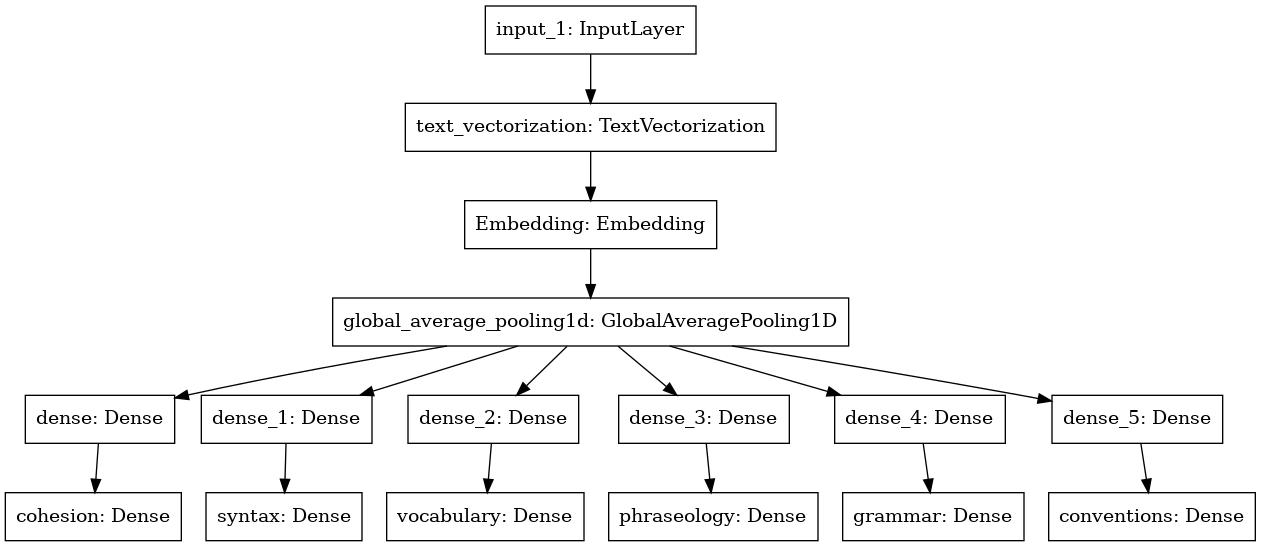

In [23]:
tf.keras.utils.plot_model(model)

In [24]:
def mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true-y_pred))

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=mean_squared_error,
    metrics=metrics
)

In [26]:
EPOCHS = 5

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
)

Epoch 1/5
108/108 [==============================] - 4s 17ms/step - loss: 41.0627 - cohesion_loss: 6.0385 - syntax_loss: 5.9672 - vocabulary_loss: 7.0736 - phraseology_loss: 7.1014 - grammar_loss: 8.3438 - conventions_loss: 6.5382 - cohesion_root_mean_squared_error: 2.4573 - syntax_root_mean_squared_error: 2.4428 - vocabulary_root_mean_squared_error: 2.6596 - phraseology_root_mean_squared_error: 2.6648 - grammar_root_mean_squared_error: 2.8886 - conventions_root_mean_squared_error: 2.5570 - val_loss: 13.7354 - val_cohesion_loss: 0.9305 - val_syntax_loss: 0.9947 - val_vocabulary_loss: 2.3407 - val_phraseology_loss: 2.6568 - val_grammar_loss: 5.4074 - val_conventions_loss: 1.4053 - val_cohesion_root_mean_squared_error: 0.9646 - val_syntax_root_mean_squared_error: 0.9973 - val_vocabulary_root_mean_squared_error: 1.5299 - val_phraseology_root_mean_squared_error: 1.6300 - val_grammar_root_mean_squared_error: 2.3254 - val_conventions_root_mean_squared_error: 1.1855
Epoch 2/5
108/108 [=======

In [27]:
print(history.history.keys())
print(sum([history.history["cohesion_root_mean_squared_error"][-1], 
           history.history["syntax_root_mean_squared_error"][-1], 
           history.history["vocabulary_root_mean_squared_error"][-1],
           history.history["phraseology_root_mean_squared_error"][-1], 
           history.history["grammar_root_mean_squared_error"][-1],
           history.history["conventions_root_mean_squared_error"][-1]
          ]))

dict_keys(['loss', 'cohesion_loss', 'syntax_loss', 'vocabulary_loss', 'phraseology_loss', 'grammar_loss', 'conventions_loss', 'cohesion_root_mean_squared_error', 'syntax_root_mean_squared_error', 'vocabulary_root_mean_squared_error', 'phraseology_root_mean_squared_error', 'grammar_root_mean_squared_error', 'conventions_root_mean_squared_error', 'val_loss', 'val_cohesion_loss', 'val_syntax_loss', 'val_vocabulary_loss', 'val_phraseology_loss', 'val_grammar_loss', 'val_conventions_loss', 'val_cohesion_root_mean_squared_error', 'val_syntax_root_mean_squared_error', 'val_vocabulary_root_mean_squared_error', 'val_phraseology_root_mean_squared_error', 'val_grammar_root_mean_squared_error', 'val_conventions_root_mean_squared_error'])
3.5987518429756165


In [28]:
train_labels.head()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.5,3.5,3.0,3.0,4.0,3.0
1,2.5,2.5,3.0,2.0,2.0,2.5
2,3.0,3.5,3.0,3.0,3.0,2.5
3,4.5,4.5,4.5,4.5,4.0,5.0
4,2.5,3.0,3.0,3.0,2.5,2.5


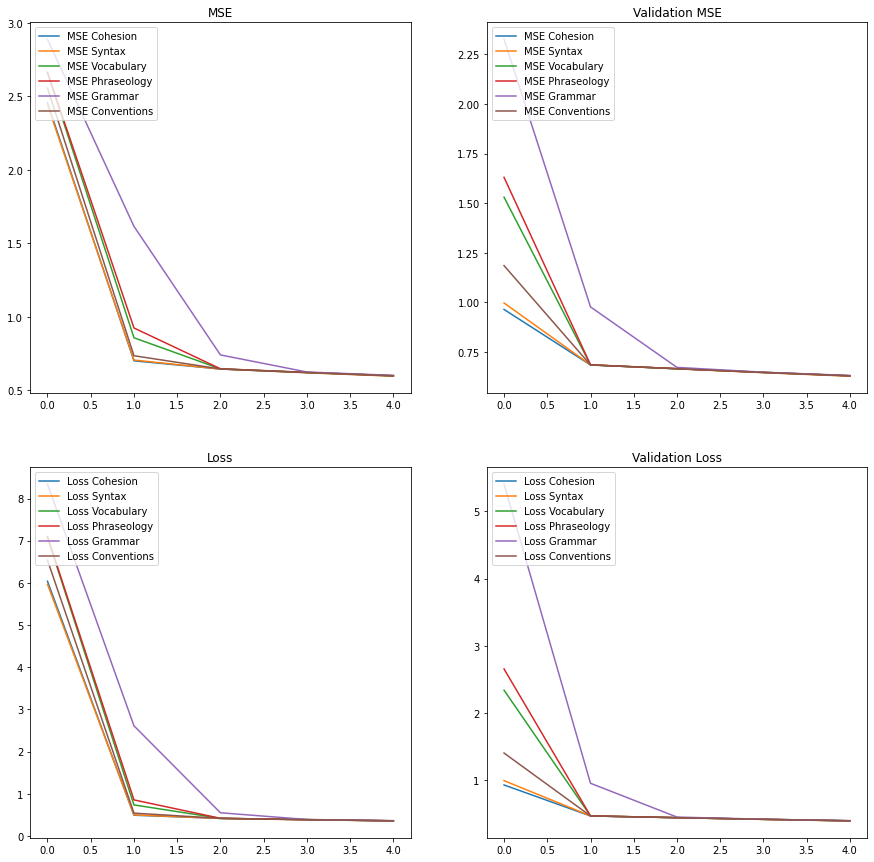

In [29]:
cohesion = history.history["cohesion_root_mean_squared_error"]
syntax = history.history["syntax_root_mean_squared_error"]
vocabulary = history.history["vocabulary_root_mean_squared_error"]
phraseology = history.history["phraseology_root_mean_squared_error"]
grammar = history.history["grammar_root_mean_squared_error"]
conventions = history.history["conventions_root_mean_squared_error"]

val_cohesion = history.history["val_cohesion_root_mean_squared_error"]
val_syntax = history.history["val_syntax_root_mean_squared_error"]
val_vocabulary = history.history["val_vocabulary_root_mean_squared_error"]
val_phraseology = history.history["val_phraseology_root_mean_squared_error"]
val_grammar = history.history["val_grammar_root_mean_squared_error"]
val_conventions = history.history["val_conventions_root_mean_squared_error"]

cohesion_loss = history.history["cohesion_loss"]
syntax_loss = history.history["syntax_loss"]
vocabulary_loss = history.history["vocabulary_loss"]
phraseology_loss = history.history["phraseology_loss"]
grammar_loss = history.history["grammar_loss"]
conventions_loss = history.history["conventions_loss"]

val_cohesion_loss = history.history["val_cohesion_loss"]
val_syntax_loss = history.history["val_syntax_loss"]
val_vocabulary_loss = history.history["val_vocabulary_loss"]
val_phraseology_loss = history.history["val_phraseology_loss"]
val_grammar_loss = history.history["val_grammar_loss"]
val_conventions_loss = history.history["val_conventions_loss"]

import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.plot(cohesion, label="MSE Cohesion")
plt.plot(syntax, label="MSE Syntax")
plt.plot(vocabulary, label="MSE Vocabulary")
plt.plot(phraseology, label="MSE Phraseology")
plt.plot(grammar, label="MSE Grammar")
plt.plot(conventions, label="MSE Conventions")
plt.title("MSE")
plt.legend(loc="upper left")

plt.subplot(2,2,2)
plt.plot(val_cohesion, label="MSE Cohesion")
plt.plot(val_syntax, label="MSE Syntax")
plt.plot(val_vocabulary, label="MSE Vocabulary")
plt.plot(val_phraseology, label="MSE Phraseology")
plt.plot(val_grammar, label="MSE Grammar")
plt.plot(val_conventions, label="MSE Conventions")
plt.title("Validation MSE")
plt.legend(loc="upper left")

plt.subplot(2,2,3)
plt.plot(cohesion_loss, label="Loss Cohesion")
plt.plot(syntax_loss, label="Loss Syntax")
plt.plot(vocabulary_loss, label="Loss Vocabulary")
plt.plot(phraseology_loss, label="Loss Phraseology")
plt.plot(grammar_loss, label="Loss Grammar")
plt.plot(conventions_loss, label="Loss Conventions")
plt.title("Loss")
plt.legend(loc="upper left")

plt.subplot(2,2,4)
plt.plot(val_cohesion_loss, label="Loss Cohesion")
plt.plot(val_syntax_loss, label="Loss Syntax")
plt.plot(val_vocabulary_loss, label="Loss Vocabulary")
plt.plot(val_phraseology_loss, label="Loss Phraseology")
plt.plot(val_grammar_loss, label="Loss Grammar")
plt.plot(val_conventions_loss, label="Loss Conventions")
plt.title("Validation Loss")
plt.legend(loc="upper left")

plt.show()

In [30]:
import random

i = int(random.randint(0, 32))
print(i)
print("")
print(text_batch[i])
print("")
print(label_batch[i])

12

tf.Tensor(b"The school board is planning to add one and a half hour to school each day. I think they should add one and a half hour to school each day because than class would be more longer, we would have to do more homework, and some students have things to do after school everyday.\n\nI disagree that the school board should add one and a half hour to school each day because class would be more longer. If schools board add one and a half hour to school each day every class would be more longer. For example my civics class is two hours if they add one and a half hour than my civics class would be two and a half hour. If class was longer teachers would have to work more. They would have to work more because than they have to make more projects and grade more papers that each student turns in. Students would have to work harder then what they usually do because they would get more work because the class is longer.\n\nSecondly I disagree because if school board adds one and a half ho

In [31]:
model.predict(tf.expand_dims(text_batch[i], 0))

[array([[3.1186094]], dtype=float32),
 array([[3.1330633]], dtype=float32),
 array([[3.1234615]], dtype=float32),
 array([[3.1092625]], dtype=float32),
 array([[3.1339204]], dtype=float32),
 array([[3.1180155]], dtype=float32)]